# Supplemental Material for Paper ID 146, On the Maximum Radius of Polynomial Lens Distortion

This notebook provides implementations and examples of content from our paper. It requires Python >= 3.6, numpy, matplotlib, and OpenCV.

Define the equation corresponding to Algorithm 1 in the paper.

In [1]:
import numpy as np

def max_radius(a, b, c):
    if c == 0.0:
        discrim = a * a  - 4 * b;
        if np.isfinite(discrim) and discrim >= 0.0:
            discrim = np.sqrt(discrim) - a;
            if discrim > 0.0:
                return 2.0 / discrim;
    else:
        # commonly used terms
        boc = b / c
        boc2 = boc * boc
        t1 = (9 * a * boc - 2 * b * boc2 - 27) / c
        t2 = 3 * a / c - boc2
        discrim = t1 * t1 + 4 * t2 * t2 * t2
        if discrim >= 0.0:
            d2=np.sqrt(discrim)
            discrim = np.cbrt((np.sqrt(discrim) + t1) / 2.0)
            soln = (discrim -  (t2 / discrim) - boc) / 3.0
            if soln > 0.0:
                return soln
        else:
            theta = (math.atan2(np.sqrt(-discrim), t1)) / 3.0
            twothirdpi = 2.0 * math.pi / 3.0
            # by construction, if discrim < 0 then t2 < 0, so the sqrt is safe
            t3 = 2.0 * np.sqrt(-t2)
            solns = [(t3 * np.cos(theta + i * twothirdpi) - boc) / 3 for i in [-1, 0, 1]]
            pos_solns = [s for s in solns if np.isfinite(s) and s > 0.0]
            if pos_solns:
                return np.min(pos_solns)
    return np.inf

Define conversions from the common distortion models to Algorithm 1.

In [2]:
def ptlens_max_radius(a, b, c):
    # convert ptlens a, b, and c to a polynomial of the form
    # (1 + a*X + b*X**2 + c*X**3)*X
    d = 1 - a - b - c
    return max_radius(2 * c / d, 3 * b / d, 4 * a / d)

# This corresponds to Algorithm 2 in the paper
def brown_max_radius(k1, k2, k3):
    # fold the constants from the derivative into a, b, and c
    a = k1 * 3
    b = k2 * 5
    c = k3 * 7
    return np.sqrt(max_radius(a, b, c))


def poly3_max_radius(k1):
    return ptlens_max_radius(0, k1, 0)


def poly5_max_radius(k1, k2):
    return brown_max_radius(k1, k2, 0)

Define the underlying distortion models, to map from the undistorted space into the distorted space, and their derivatives.

In [3]:
def brown_distort(X, k1, k2, k3):
    return (1 + k1 * X ** 2 + k2 * X ** 4 + k3 * X ** 6) * X


def ptlens_distort(X, a, b, c):
    return ((1 - a - b - c) + c * X + b * X ** 2 + a * X ** 3) * X


def poly3_distort(X, k1):
    return ptlens_distort(X, 0, k1, 0)


def poly5_distort(X, k1, k2):
    return brown_distort(X, k1, k2, 0)


def brown_distort_deriv(X, k1, k2, k3):
    return 1 + 3 * k1 * X ** 2 + 5 * k2 * X ** 4 + 7 * k3 * X ** 6


def ptlens_distort_deriv(X, a, b, c):
    return (1 - a - b - c) + 2 * c * X + 3 * b * X ** 2 + 4 * a * X ** 3


def poly3_distort_deriv(X, k1):
    return ptlens_distort_deriv(X, 0, k1, 0)


def poly5_distort_deriv(X, k1, k2):
    return brown_distort_deriv(X, k1, k2, 0)

Define a helper to evaluate the max radius for any of the models in the lensfun database.

In [4]:
def max_radius_any_model(param_dict):
    """
    param_dict: dict[str, float | str]
        mapping between names and values for the required parameters
        or 'model' and the model name
    """
    model = param_dict["model"]
    if model == "ptlens":
        a, b, c = param_dict["a"], param_dict["b"], param_dict["c"]
        undistorted_max_r = ptlens_max_radius(a, b, c)
        distorted_max_r = (ptlens_distort(undistorted_max_r, a, b, c) 
                            if np.isfinite(undistorted_max_r) else np.inf)
    elif model == "brown":
        k1, k2, k3 = param_dict["k1"], param_dict["k2"], param_dict["k3"]
        undistorted_max_r = brown_max_radius(k1, k2, k3)
        distorted_max_r = (brown_distort(undistorted_max_r, k1, k2, k3)
                            if np.isfinite(undistorted_max_r) else np.inf)
    elif model == "poly3":
        k1 = param_dict["k1"]
        undistorted_max_r = poly3_max_radius(k1)
        distorted_max_r = (poly3_distort(undistorted_max_r, k1) 
                            if np.isfinite(undistorted_max_r) else np.inf)
    elif model == "poly5":
        k1, k2 = param_dict["k1"], param_dict["k2"]
        undistorted_max_r = poly5_max_radius(k1, k2)
        distorted_max_r = (poly5_distort(undistorted_max_r, k1, k2)
                            if np.isfinite(undistorted_max_r) else np.inf)
    else:
        raise ValueError(f"Model {model} not supported")
    return undistorted_max_r, distorted_max_r

Evaluate several models taken from the lensfun database.

In [5]:
def print_results(param_dict, camera_name="camera"):
    undistorted_max_r, distorted_max_r = max_radius_any_model(param_dict)
    print(f"For camera '{camera_name}' with model {param_dict['model']}, " +
          f"the max radius in distorted space was {distorted_max_r:02f} " +
          f"while the max valid radius in undistorted space was {undistorted_max_r}\n")

print_results({"model": "poly3", "k1": -0.001195},
              "Canon EF 100-300mm f/5.6L")
print_results({"model": "ptlens", "a": -0.000930, "b": -0.002160, "c": -0.002400},
              "Zeiss Loxia 50mm f/2 Planar T*")
print_results({"model": "poly5", "k1": -0.015375784, "k2": 0.00166965},
              "Fixed lens PowerShot G12 8.108mm")

For camera 'Canon EF 100-300mm f/5.6L' with model poly3, the max radius in distorted space was 11.154296 while the max valid radius in undistorted space was 16.711473939402715

For camera 'Zeiss Loxia 50mm f/2 Planar T*' with model ptlens, the max radius in distorted space was 4.278478 while the max valid radius in undistorted space was 5.873475972303261

For camera 'Fixed lens PowerShot G12 8.108mm' with model poly5, the max radius in distorted space was inf while the max valid radius in undistorted space was inf



Plot the distortion function and its derivative for the Zeiss Loxia 50mm f/2 Planar T* camera.

max radius 5.873475972303261


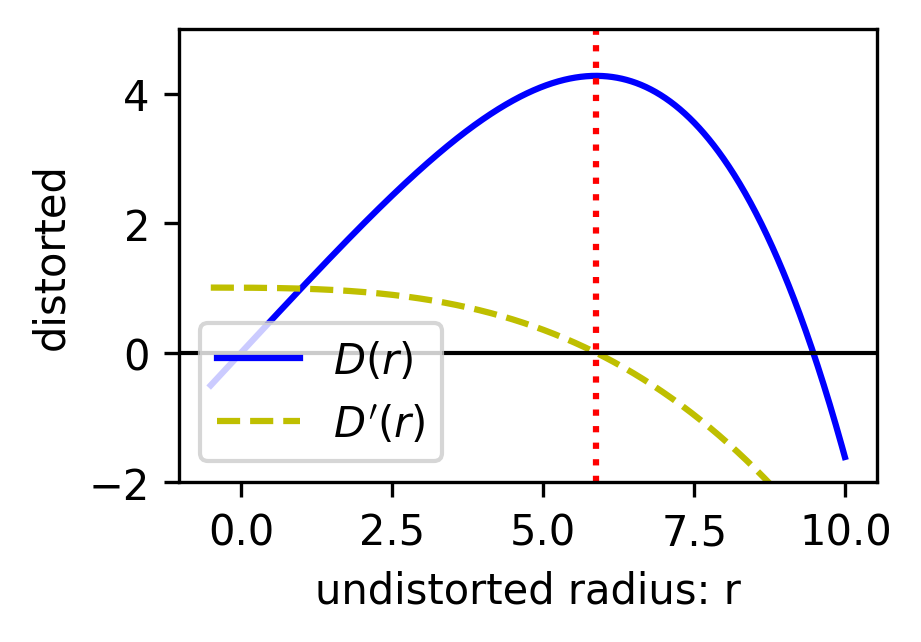

In [6]:
import matplotlib.pyplot as plt

a, b, c = -0.000930, -0.002160, -0.002400
r_max = ptlens_max_radius(a, b, c)
print("max radius", r_max)

x = np.arange(-0.5,10,0.01)
y = ptlens_distort(x, a, b, c)
plt.figure(figsize=(3,2), dpi=300)
dr, = plt.plot(x,y,'b')
dr.set_label("$D(r)$")
y2 = ptlens_distort_deriv(x, a, b, c)
ddr, = plt.plot(x,y2,"y--")
ddr.set_label("$D\'(r)$")

plt.axvline(x=r_max,color='r',ls=":")
plt.axhline(y=0,color='k',lw=1)
plt.xlabel("undistorted radius: r")
plt.ylabel("distorted")
plt.ylim([-2,5])
plt.legend(loc=3)

Below is raw image taken a Reolink RLC-410S security camera. Note that lines which should be straight are slightly curved due to distortion.

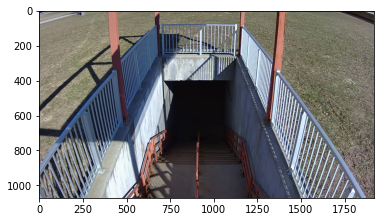

In [7]:
import cv2
img = cv2.imread("G509.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA))

Below is the undistorted version of this image using distortion parameters we calculated. Note that lines which should be straight are roughly so within the maximum valid radius, but are severely distorted outside these bounds.

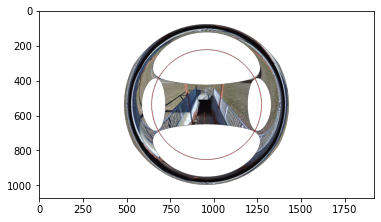

In [8]:
# Define distortion coefficients
brown_k1 = -3.902141688184989632e-01
brown_k2 = 2.375784064646617455e-01
brown_k3 = -1.108957743129092843e-01

# Define OpenCV distortion terms and projection matrix
D = np.array([brown_k1, brown_k2, 0, 0, brown_k3])
K = np.array([[1453.39996, 0.0, 959.5],
              [0.0, 1453.39996 , 535.5],
              [0, 0, 1]])

# Compute the maximum valid radius
max_r = brown_max_radius(brown_k1, brown_k2, brown_k3)

# Visualization
K2 = K.copy()
OUTPUT_SCALE = 0.2
K2[0,0] *= OUTPUT_SCALE
K2[1,1] *= OUTPUT_SCALE
img = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
# Undistort the image
img_ud = cv2.undistort(img, K, D, K2, newCameraMatrix=K2)
# Scale the max radius into the undistorted visualization space
rad = int(max_r * K2[0,0])
# Draw a circle about the center of the undistored image
img_ud = cv2.circle(img_ud, (960, 536), rad, (0,0,255,255), 2)

img_ud = cv2.cvtColor(img_ud, cv2.COLOR_BGRA2RGBA)
plt.imshow(img_ud)

Here we show the behavior of the maximum valid radius function based on the input parameters a, b, and c.

In [9]:
import math
import copy
rng = 5
nplots = 5
x = np.linspace(-rng,rng,200)
y = np.linspace(-rng,rng,200)
z = np.linspace(-rng,rng,nplots)

X, Y = np.meshgrid(x,y)
D = np.zeros(X.shape + (nplots,), dtype=float)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        for k in range(len(z)):
            D[i,j,k] = brown_max_radius(X[i,j], Y[i,j], z[k])

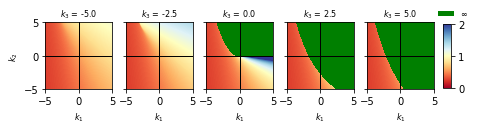

In [10]:
from matplotlib.patches import Patch

cmap=copy.copy(plt.cm.RdYlBu)
cmap.set_bad('g')

fig, axs = plt.subplots(1, nplots, figsize=(6.5,1.7), sharey=True)

for i in range(nplots):
    pcm = axs[i].imshow(D[:,:,i], extent=[-rng,rng,-rng,rng], vmin=0, vmax=2, cmap=cmap, origin="lower")
    axs[i].set_title("$k_3$ = "+str(z[i]), fontsize=8)
    axs[i].set_xlabel("$k_1$", fontsize=8)
    axs[i].axhline(0, color='black', lw=1.0)
    axs[i].axvline(0, color='black', lw=1.0)

axs[0].set_ylabel("$k_2$", fontsize=8)

plt.subplots_adjust(left=0.08, bottom=0.05, right=1.08, top=1, wspace=0.2, hspace=0)
fig.colorbar(pcm,ax=axs[:],shrink=0.55,aspect=8, pad=0.02)
legend_elements = [Patch(facecolor='g', label='$\infty$')]
plt.legend(handles=legend_elements, bbox_to_anchor=(0.95, 1.3), loc='upper left', ncol=1,frameon=False,prop={'size': 8})